In [87]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
from scipy.stats import norm, gaussian_kde, anderson, anderson_ksamp
from scipy.integrate import cumulative_trapezoid
from scipy.interpolate import interp1d
from scipy.integrate import quad

In [88]:
#calculate the Pagamma in the massive limit, following https://arxiv.org/pdf/2208.04333.pdf
Np=100 #number of modes in the gaussian magnetic field
h_vec = np.arange(-Np,Np+1) 
Wh = np.random.normal(0, 1, 2*Np+1) #white noise in the real space to build the magnetic field
#white noise in the k space
Wtildeh=np.array([      
        sum(Wh*np.exp(2*math.pi*h_vec*1j*j_it/Np))/np.sqrt(2*Np+1)
        for j_it in range(0,2*Np+1)]
        )
#3D power spectrum of the magnetic field
def P3D(k):
    B=3 #muG
    L=30 #kpc
    const=9.00978*10**(91) * (B**2) *(L**2)#normalization to the average properties
    kp=2*math.pi/10 #kpc^-1
    return const/(1+(k/kp)**(11/3))

def P1D(eta,kperp_min,kperp_max):
    integrand = lambda kperp: P3D(np.sqrt(eta**2+kperp**2))*(1-(kperp**2)/(2*(eta**2+kperp**2)))*kperp/(16*math.pi**3)
    result, _ = quad(integrand, kperp_min, kperp_max)
    return result #in kpc^-2

def flux(x):
    return (x**2 +1)**(-1)

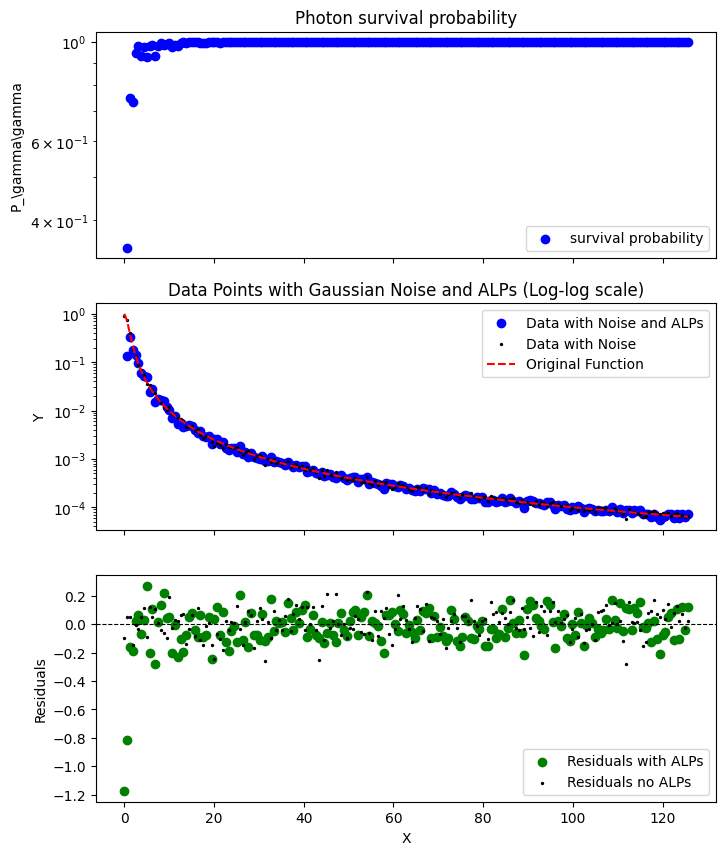

In [93]:
####################################################################
gag=3*10**(-11) #GeV^-1
ma=0.01 #neV
omg=3 #keV
L=10 #kpc --length of the magnetic field
eta=((ma**2)/(2*omg))*156000 #kpc^-1

kmin=1 #kpc^-1
kmax=10 #kpc^-1

k_vec=np.array([
    2*math.pi*j_it/L
    for j_it in range(0,2*Np+1)]) #kpc^-1

Pagamma=np.real(np.array([
    (P1D(k_vec[ii],kmin,kmax)*(abs(Wtildeh[ii])**2)*(gag**2)/4)*4.10093*10**(-71)
    for ii in range(0,2*Np+1)]
    ))


######################################################
    
points_ax=np.array([
    flux(k_vec[ii])*(1-Pagamma[ii]) + np.random.normal(noise_mean, noise_std*flux(k_vec[ii]))
    for ii in range(0,2*Np+1)]
    )

points_noax=np.array([
    flux(k_vec[ii]) + np.random.normal(noise_mean, noise_std*flux(k_vec[ii]))
    for ii in range(0,2*Np+1)]
    )

# Calculate residuals
residuals = (points_ax - flux(k_vec))/flux(k_vec)
# Calculate residuals
residuals_noax = (points_noax - flux(k_vec))/flux(k_vec)

# Plotting
fig, (ax0,ax1, ax2) = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

ax0.scatter(k_vec, 1-Pagamma, color='blue', label='survival probability')
ax0.set_yscale('log')
ax0.set_ylabel('P_\gamma\gamma')
ax0.set_title('Photon survival probability')
ax0.legend()
ax0.grid(False)

# Upper panel: Original function, oscillated and data with noise
ax1.scatter(k_vec, points_ax, color='blue', label='Data with Noise and ALPs')
ax1.scatter(k_vec, points_noax, color='black', label='Data with Noise', s=2)
ax1.plot(k_vec, flux(k_vec), color='red', linestyle='--', label='Original Function')
ax1.set_yscale('log')
ax1.set_ylabel('Y')
ax1.set_title('Data Points with Gaussian Noise and ALPs (Log-log scale)')
ax1.legend()
ax1.grid(False)

# Lower panel: Residuals
ax2.scatter(k_vec, residuals, color='green', label='Residuals with ALPs')
ax2.scatter(k_vec, residuals_noax, color='black', label='Residuals no ALPs', s=2)
ax2.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax2.set_xlabel('X')
ax2.set_ylabel('Residuals')
ax2.legend()
ax2.grid(False)

plt.show()

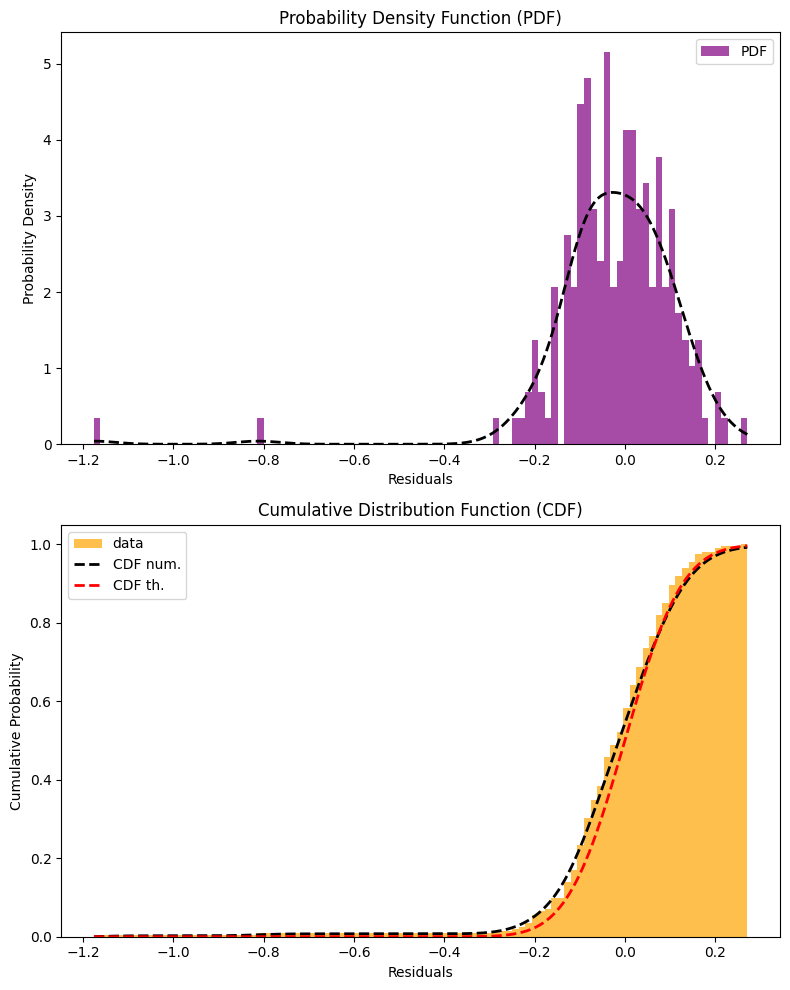

CDF (this should be around 0.67): 0.6097389535803942


In [94]:
# KDE for PDF
kde = gaussian_kde(residuals)
xmin = min(residuals)
xmax = max(residuals)
x_smooth = np.linspace(xmin, xmax, num_points)
pdf_smooth = kde(x_smooth)
# Numerical integration for CDF
cdf_smooth = cumulative_trapezoid(pdf_smooth, x_smooth, initial=0)
#analytical CDF for Gaussian noise
cdf_th = norm.cdf(x_smooth, noise_mean, noise_std)

# KDE for PDF
kde_noax = gaussian_kde(residuals_noax)
xmin_noax = min(residuals_noax)
xmax_noax = max(residuals_noax)
x_smooth_noax = np.linspace(xmin_noax, xmax_noax, num_points)
pdf_smooth_noax = kde(x_smooth_noax)
# Numerical integration for CDF
cdf_smooth_noax = cumulative_trapezoid(pdf_smooth_noax, x_smooth_noax, initial=0)
#analytical CDF for Gaussian noise
cdf_th_noax = norm.cdf(x_smooth_noax, noise_mean, noise_std)

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot PDF
ax1.hist(residuals, bins=100, density=True, color='purple', alpha=0.7, label='PDF')
xmin, xmax = ax1.get_xlim()
ax1.plot(x_smooth, pdf_smooth, 'k--', linewidth=2)
ax1.set_xlabel('Residuals')
ax1.set_ylabel('Probability Density')
ax1.set_title('Probability Density Function (PDF)')
ax1.legend()

# Plot CDF
ax2.hist(residuals, bins=100, density=True, cumulative=True, color='orange', alpha=0.7, label='CDF')
#ax2.hist(residuals_noax, bins=100, density=True, cumulative=True, color='pink', alpha=0.7, label='CDF')
ax2.plot(x_smooth, cdf_smooth, 'k--', linewidth=2)
ax2.plot(x_smooth, cdf_th, 'r--', linewidth=2)
ax2.legend(["data", "CDF num.","CDF th."], loc ="upper left")
ax2.set_xlabel('Residuals')
ax2.set_ylabel('Cumulative Probability')
ax2.set_title('Cumulative Distribution Function (CDF)')
#ax2.legend()

plt.tight_layout()
plt.show()

#Crosscheck
# Create an interpolation function for the CDF
cdf_interp = interp1d(x_smooth, cdf_smooth, kind='linear')

print("CDF (this should be around 0.67):", cdf_interp(noise_mean+noise_std)-cdf_interp(noise_mean-noise_std))

In [95]:
# Perform the Anderson-Darling test
result = anderson(residuals, dist='norm')

# Print the test statistic and critical values
print("Anderson-Darling test statistic:", result.statistic)
print("Critical values:", result.critical_values)

# Determine significance
significance_level = 0.05
is_significant = result.statistic > result.critical_values[2]  # Compare with the critical value at index 2 for 5% significance level
print("Is the test significant at 5% level?", is_significant)

Anderson-Darling test statistic: 4.836102554510603
Critical values: [0.565 0.644 0.772 0.901 1.071]
Is the test significant at 5% level? True


In [96]:
# Perform the Anderson-Darling test
result = anderson(residuals_noax, dist='norm')

# Print the test statistic and critical values
print("Anderson-Darling test statistic:", result.statistic)
print("Critical values:", result.critical_values)

# Determine significance
significance_level = 0.05
is_significant = result.statistic > result.critical_values[2]  # Compare with the critical value at index 2 for 5% significance level
print("Is the test significant at 5% level?", is_significant)

Anderson-Darling test statistic: 0.464447405111855
Critical values: [0.565 0.644 0.772 0.901 1.071]
Is the test significant at 5% level? False
